## Imports y datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

import pickle

RANDOM_STATE = 42

In [2]:
original = pd.read_csv('Datasets/hotels_procesado.csv').copy()
original_test = pd.read_csv('Datasets/hotels_test.csv').copy()
train = pd.read_csv('Datasets/train_encoded.csv').copy()
test = pd.read_csv('Datasets/test_encoded.csv').copy()

### Split train/test

In [3]:
x = train.copy()
y = original['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=RANDOM_STATE) #semilla

In [4]:
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 37192
# Datos Prueba: 15940
% Positivos Entrenamiento: 50.863
% Positivos Prueba: 50.866


Normalizo los datos para obtener una mejor performance de los modelos.

In [5]:
stand_scaler = StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm=stand_scaler.transform(x_test)

## K-Nearest Neighbors (KNN)

In [6]:
#Crear el modelo con parámetros por defecto
KNN_Classifier = KNeighborsClassifier()

In [7]:
#Entrenar el modelo
KNN_Classifier.fit(x_train, y_train)

#Predicción sobre test
y_pred = KNN_Classifier.predict(x_test)

In [8]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("f1 score: "+str(f1))

Accuracy: 0.5874529485570891
f1 score: 0.596068796068796


### Aproximacion inicial a la cantidad de vecinos del modelo

In [11]:
# Variamos la cantidad de vecinos (K)

metrics = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(30,50) # vecinos desde 1 hasta cantidad total de puntos en test

for n in k_range:

    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    metrics.append((n, (y_test == y_pred).sum()))

In [ ]:
# ploteamos

df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

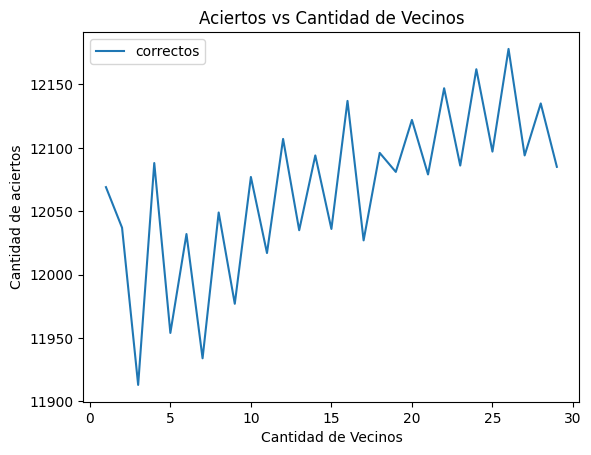

In [7]:
# ploteamos

df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

In [9]:
k_range = range(20,30) #cantidad de vecinos a probar

k_scores = [] # f1score para cada K utilizado
scorer_fn = make_scorer(sk.metrics.f1_score)

for k in k_range:
    #clasificador Knn
    knn = KNeighborsClassifier(n_neighbors=k)
    #uso 10 folds
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring=scorer_fn, verbose=2)
    #promedio las 10 métricas
    k_scores.append(scores.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  10.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s


[CV] END .................................................... total time=  10.6s
[CV] END .................................................... total time=  10.5s
[CV] END .................................................... total time=   9.3s
[CV] END .................................................... total time=  11.0s
[CV] END .................................................... total time=   8.9s
[CV] END .................................................... total time=  10.6s
[CV] END .................................................... total time=   9.0s
[CV] END .................................................... total time=  10.9s
[CV] END .................................................... total time=  10.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   9.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV] END .................................................... total time=  11.7s
[CV] END .................................................... total time=  11.9s
[CV] END .................................................... total time=  10.8s
[CV] END .................................................... total time=  11.0s
[CV] END .................................................... total time=  11.7s
[CV] END .................................................... total time=  10.6s
[CV] END .................................................... total time=  11.1s
[CV] END .................................................... total time=  10.4s
[CV] END .................................................... total time=  12.4s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  10.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s


[CV] END .................................................... total time=  11.7s
[CV] END .................................................... total time=  13.8s
[CV] END .................................................... total time=  10.4s
[CV] END .................................................... total time=   8.5s
[CV] END .................................................... total time=   8.6s
[CV] END .................................................... total time=   8.0s
[CV] END .................................................... total time=   8.6s
[CV] END .................................................... total time=   9.0s
[CV] END .................................................... total time=   9.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   9.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV] END .................................................... total time=   9.0s
[CV] END .................................................... total time=   8.3s
[CV] END .................................................... total time=   8.6s
[CV] END .................................................... total time=  11.0s
[CV] END .................................................... total time=  10.7s
[CV] END .................................................... total time=  10.9s
[CV] END .................................................... total time=  11.0s
[CV] END .................................................... total time=  17.8s
[CV] END .................................................... total time=  18.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  11.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV] END .................................................... total time=  14.1s
[CV] END .................................................... total time=   8.6s
[CV] END .................................................... total time=   9.2s
[CV] END .................................................... total time=  13.0s
[CV] END .................................................... total time=  18.7s
[CV] END .................................................... total time=  13.0s
[CV] END .................................................... total time=   8.5s
[CV] END .................................................... total time=   9.8s
[CV] END .................................................... total time=   8.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  10.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] END .................................................... total time=   9.3s
[CV] END .................................................... total time=  10.6s
[CV] END .................................................... total time=  11.9s
[CV] END .................................................... total time=  10.6s
[CV] END .................................................... total time=  13.3s
[CV] END .................................................... total time=  11.7s
[CV] END .................................................... total time=  11.7s
[CV] END .................................................... total time=  12.0s
[CV] END .................................................... total time=  12.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  12.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.1s remaining:    0.0s


[CV] END .................................................... total time=  12.2s
[CV] END .................................................... total time=  10.7s
[CV] END .................................................... total time=  13.5s
[CV] END .................................................... total time=  13.2s
[CV] END .................................................... total time=  10.4s
[CV] END .................................................... total time=  12.0s
[CV] END .................................................... total time=  14.0s
[CV] END .................................................... total time=  15.3s
[CV] END .................................................... total time=  14.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  12.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.7s remaining:    0.0s


[CV] END .................................................... total time=  16.8s
[CV] END .................................................... total time=  11.8s
[CV] END .................................................... total time=  11.1s
[CV] END .................................................... total time=  13.5s
[CV] END .................................................... total time=  14.0s
[CV] END .................................................... total time=  16.4s
[CV] END .................................................... total time=  13.8s
[CV] END .................................................... total time=  18.0s
[CV] END .................................................... total time=  11.6s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  16.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.7s remaining:    0.0s


[CV] END .................................................... total time=  13.9s
[CV] END .................................................... total time=  12.6s
[CV] END .................................................... total time=  12.1s
[CV] END .................................................... total time=  12.4s
[CV] END .................................................... total time=  12.7s
[CV] END .................................................... total time=  13.5s
[CV] END .................................................... total time=  13.5s
[CV] END .................................................... total time=  12.4s
[CV] END .................................................... total time=  15.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  19.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.1s remaining:    0.0s


[CV] END .................................................... total time=  12.0s
[CV] END .................................................... total time=  13.4s
[CV] END .................................................... total time=  18.3s
[CV] END .................................................... total time=  12.4s
[CV] END .................................................... total time=  13.0s
[CV] END .................................................... total time=  12.8s
[CV] END .................................................... total time=  10.6s
[CV] END .................................................... total time=  12.9s
[CV] END .................................................... total time=  12.4s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.3min finished


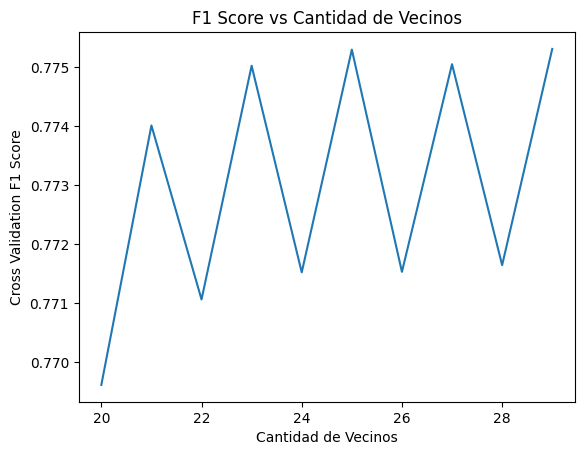

In [10]:
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation F1 Score')
plt.title('F1 Score vs Cantidad de Vecinos')
plt.show()

### Random Search Cross Validation

In [16]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid={ 'n_neighbors': [35], 
              'weights':['distance'],
              'algorithm':['kd_tree'],
              'metric':['manhattan'],
             }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)

#Clasificador
knn_model = KNeighborsClassifier()

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_knn = RandomizedSearchCV(estimator = knn_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_iter = n,
                              random_state=RANDOM_STATE, verbose=2) 

rand_knn.fit(x_train, y_train)
rand_knn.cv_results_['mean_test_score']

c:\Program Files\Python38\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  15.2s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  13.0s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  17.4s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  15.2s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  11.7s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  19.1s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  13.1s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  10.5s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=50, weights=distance; total time=  13.2s
[CV] END algorithm=kd_tree, metric=manhattan, n_

array([0.62076846])

In [17]:
print('Mejores parámetros: {}'.format(rand_knn.best_params_))
print('Mejor métrica: {}'.format(rand_knn.best_score_))

Mejores parámetros: {'weights': 'distance', 'n_neighbors': 50, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
Mejor métrica: 0.6207684594738014


In [18]:
knn = KNeighborsClassifier().set_params(**rand_knn.best_params_)
modelo_knn = knn.fit(x_train, y_train)
y_pred = modelo_knn.predict(x_test)

In [ ]:
#pickle.dump(arbol, open('knn_grupo29.pickle', 'wb'))

### Métricas

In [19]:
print(f'Best Training Accuracy: {modelo_knn.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo_knn.score(x_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(rand_knn.best_estimator_, x, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 1.0
Best Testing Accuracy: 0.623651191969887
Cross-val-score: 0.6212075959847223


In [20]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.623651191969887
Recall: 0.6133448445979279
Precision: 0.6345540385351538
f1 score: 0.623769206647852


In [21]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.61      0.63      0.62      7832
           1       0.63      0.61      0.62      8108

    accuracy                           0.62     15940
   macro avg       0.62      0.62      0.62     15940
weighted avg       0.62      0.62      0.62     15940



In [22]:
print(classification_report(y_train, modelo_knn.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18275
           1       1.00      1.00      1.00     18917

    accuracy                           1.00     37192
   macro avg       1.00      1.00      1.00     37192
weighted avg       1.00      1.00      1.00     37192



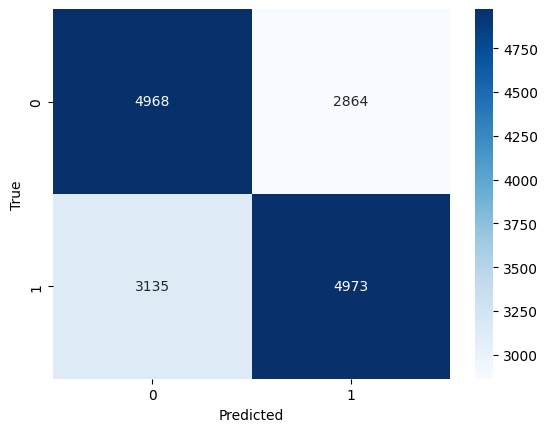

In [23]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Submission

In [27]:
X_submission_knn = test.select_dtypes(exclude=['object'])
y_pred_test_knn = modelo_knn.predict(X_submission_knn)
df_submission_knn = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_knn})
df_submission_knn.to_csv('knn00.csv', index=False)

## Support Vector Machine (SVM)

### Random Search Cross Validation

In [6]:
#Crear el modelo con parámetros por defecto
SVM_Classifier = SVC()

In [7]:
#Entrenar el modelo
SVM_Classifier.fit(x_train, y_train)

#Predicción sobre test
y_pred = SVM_Classifier.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("f1 score: "+str(f1))

### Random Search Cross Validation

In [ ]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid= {'kernel': ['linear'],
              'C': [10]
              }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)

#Clasificador
knn_model = SVC()

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_svm = RandomizedSearchCV(estimator = knn_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              n_iter = n,
                              random_state=RANDOM_STATE, verbose=2) 

rand_svm.fit(x_train, y_train)
rand_svm.cv_results_['mean_test_score']

In [ ]:
print('Mejores parámetros: {}'.format(rand_svm.best_params_))
print('Mejor métrica: {}'.format(rand_svm.best_score_))

In [ ]:
svm = SVC(random_state=RANDOM_STATE).set_params(**rand_svm.best_params_)
modelo_svm = svm.fit(x_train, y_train)
y_pred = modelo_svm.predict(x_test)

In [ ]:
#pickle.dump(arbol, open('svm_grupo29.pickle', 'wb'))

### Métricas

In [ ]:
print(f'Best Training Accuracy: {modelo_svm.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo_svm.score(x_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(rand_svm.best_estimator_, x, y, cv=StratifiedKFold(shuffle=True)).mean()}')

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

In [ ]:
print(classification_report(y_train, modelo_svm.predict(x_train)))

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Submission

In [ ]:
X_submission_svm = test.select_dtypes(exclude=['object'])
y_pred_test_svm = modelo_svm.predict(X_submission_svm)
df_submission_svm = pd.DataFrame({'id': test['id'], 'is_canceled': y_pred_test_svm})
df_submission_svm.to_csv('svm00.csv', index=False)

## Random Forest

### Random Search Cross Validation

### Métricas

### Submission